In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chahatag","key":"34369903714326fed99b0188a27f4f8e"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d wordsforthewise/lending-club

Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 99% 1.26G/1.26G [00:06<00:00, 255MB/s]
100% 1.26G/1.26G [00:06<00:00, 221MB/s]


In [5]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [6]:
SAMPLE_ROWS = 100_000
df = pd.read_csv("accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", nrows=SAMPLE_ROWS, low_memory=False)
print(df.shape)
df.head()

(100000, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 115.2+ MB


In [8]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)

,0
member_id,1.00000
sec_app_num_rev_accts,1.00000
sec_app_open_act_il,1.00000
sec_app_inq_last_6mths,1.00000
sec_app_open_acc,1.00000
sec_app_mort_acc,1.00000
sec_app_mths_since_last_major_derog,1.00000
sec_app_collections_12_mths_ex_med,1.00000
sec_app_chargeoff_within_12_mths,1.00000
sec_app_fico_range_low,1.00000


In [9]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,70288
Charged Off,17603
Current,11402
Late (31-120 days),441
In Grace Period,199
Late (16-30 days),66
Default,1


In [10]:
def map_target(x):
    x = str(x).lower()
    if "fully paid" in x:
        return 0
    if "charged off" in x or "default" in x:
        return 1
    return np.nan

df['target'] = df['loan_status'].apply(map_target)

In [11]:
df['target'].value_counts(dropna=False)

,count
target,
0.0,70288
1.0,17604
NaN,12108


In [12]:
numerical_cols = df.select_dtypes(include=['number']).columns
corr = df[numerical_cols].corr()['target'].sort_values(ascending=False)
corr.head(15)

,target
target,1.000000
recoveries,0.500833
collection_recovery_fee,0.497627
int_rate,0.307837
hardship_dpd,0.287415
orig_projected_additional_accrued_interest,0.210954
hardship_amount,0.202099
hardship_payoff_balance_amount,0.186596
acc_open_past_24mths,0.138803
total_rec_late_fee,0.119344


In [13]:
important_features = [
    'loan_amnt','funded_amnt','int_rate_clean','installment','term','annual_inc',
    'emp_length','home_ownership','verification_status','purpose','grade','sub_grade',
    'dti','delinq_2yrs','inq_last_6mths','open_acc','revol_bal','total_acc'
]

len(important_features), important_features


(18,
 ['loan_amnt',
  'funded_amnt',
  'int_rate_clean',
  'installment',
  'term',
  'annual_inc',
  'emp_length',
  'home_ownership',
  'verification_status',
  'purpose',
  'grade',
  'sub_grade',
  'dti',
  'delinq_2yrs',
  'inq_last_6mths',
  'open_acc',
  'revol_bal',
  'total_acc'])

In [14]:
leakage_cols = [
    'total_pymnt','recoveries','last_pymnt_amnt','collections_12_mths_ex_med',
    'tot_cur_bal','total_rev_hi_lim','zip_code','issue_d','earliest_cr_line',
    'title','desc','url'
]

for col in leakage_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

In [15]:
OUT_DIR = "/content/cleaned_data"
os.makedirs(OUT_DIR, exist_ok=True)

In [16]:
keep_cols = [
    'loan_amnt','funded_amnt','int_rate','term','installment','grade','sub_grade',
    'emp_length','home_ownership','annual_inc','verification_status','purpose',
    'addr_state','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec',
    'revol_bal','total_acc','loan_status'
]

In [17]:
def clean_chunk(df):
    df = df[[c for c in keep_cols if c in df.columns]].copy()
    if 'int_rate' in df:
        df['int_rate'] = (
            df['int_rate']
            .astype(str)
            .str.rstrip('%')
            .replace('nan', np.nan)
            .astype(float)
        )
    if 'term' in df:
        df['term'] = df['term'].astype(str).str.extract('(\d+)').astype(float)
    if 'emp_length' in df:
        df['emp_length'] = (
            df['emp_length']
            .replace({'< 1 year':'0', '10+ years':'10'})
            .astype(str)
            .str.extract('(\d+)')
            .astype(float)
        )
    def map_status(x):
        x = str(x).lower()
        if "fully paid" in x: return 0
        if "charged off" in x or "default" in x: return 1
        return np.nan

    df["target"] = df["loan_status"].apply(map_status).astype("float")
    df.drop(columns=["loan_status"], inplace=True)
    df = df.dropna(subset=["target"])

    return df

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1281308926.py:12: SyntaxWarning: invalid escape sequence '\d'
  df['term'] = df['term'].astype(str).str.extract('(\d+)').astype(float)
/tmp/ipython-input-1281308926.py:18: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+)')


In [18]:
import pyarrow.parquet as pq
import pyarrow as pa

DATA_PATH = "accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv"
CHUNK_SIZE = 100_000

reader = pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE, low_memory=False)

for i, chunk in enumerate(reader):
    print(f"Processing chunk {i} — shape {chunk.shape}")

    clean_df = clean_chunk(chunk)
    out_file = f"{OUT_DIR}/clean_chunk_{i:03d}.parquet"
    clean_df.to_parquet(out_file, index=False)

    print(f"Saved → {out_file}")

Processing chunk 0 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_000.parquet
Processing chunk 1 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_001.parquet
Processing chunk 2 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_002.parquet
Processing chunk 3 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_003.parquet
Processing chunk 4 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_004.parquet
Processing chunk 5 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_005.parquet
Processing chunk 6 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_006.parquet
Processing chunk 7 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_007.parquet
Processing chunk 8 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_008.parquet
Processing chunk 9 — shape (100000, 151)
Saved → /content/cleaned_data/clean_chunk_009.parquet
Processing chunk 10 — shape (100000, 151)
Saved → 

In [19]:
import glob

files = sorted(glob.glob(f"{OUT_DIR}/*.parquet"))
dfs = [pd.read_parquet(f) for f in files]

full_df = pd.concat(dfs, ignore_index=True)
print("Final cleaned dataset shape:", full_df.shape)
full_df.head()

Final cleaned dataset shape: (1348099, 21)


,loan_amnt,funded_amnt,int_rate,term,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,target
0,3600.0,3600.0,13.99,36.0,123.03,C,C4,10.0,MORTGAGE,55000.0,...,debt_consolidation,PA,5.91,0.0,1.0,7.0,0.0,2765.0,13.0,0.0
1,24700.0,24700.0,11.99,36.0,820.28,C,C1,10.0,MORTGAGE,65000.0,...,small_business,SD,16.06,1.0,4.0,22.0,0.0,21470.0,38.0,0.0
2,20000.0,20000.0,10.78,60.0,432.66,B,B4,10.0,MORTGAGE,63000.0,...,home_improvement,IL,10.78,0.0,0.0,6.0,0.0,7869.0,18.0,0.0
3,10400.0,10400.0,22.45,60.0,289.91,F,F1,3.0,MORTGAGE,104433.0,...,major_purchase,PA,25.37,1.0,3.0,12.0,0.0,21929.0,35.0,0.0
4,11950.0,11950.0,13.44,36.0,405.18,C,C3,4.0,RENT,34000.0,...,debt_consolidation,GA,10.20,0.0,0.0,5.0,0.0,8822.0,6.0,0.0


In [20]:
import glob, os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

OUT_DIR = "/content/cleaned_data"
PARQUET_FILES = sorted(glob.glob(os.path.join(OUT_DIR, "clean_chunk_*.parquet")))
print("Found parquet files:", len(PARQUET_FILES))
assert len(PARQUET_FILES) > 0, "No parquet files found in OUT_DIR"

Found parquet files: 23


In [21]:
dfs = []
for f in PARQUET_FILES:
    dfs.append(pd.read_parquet(f))
full_df = pd.concat(dfs, ignore_index=True)
print("Combined cleaned shape:", full_df.shape)
full_df['target'] = full_df['target'].astype(int)

Combined cleaned shape: (1348099, 21)


In [22]:
numerical_cols = [c for c in [
    'loan_amnt','funded_amnt','int_rate','installment','term','annual_inc',
    'dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc','emp_length'
] if c in full_df.columns]

categorical_cols = [c for c in [
    'grade','sub_grade','home_ownership','verification_status','purpose','addr_state'
] if c in full_df.columns]

print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

Numerical: ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'term', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'emp_length']
Categorical: ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']


In [23]:
full_df['annual_inc'] = full_df['annual_inc'].replace(0, np.nan)
full_df[numerical_cols] = full_df[numerical_cols].fillna(full_df[numerical_cols].median())

In [24]:
X = full_df[numerical_cols + categorical_cols].copy()
y = full_df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (1078479, 20) (269620, 20)


In [25]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')
preprocessor.fit(X_train)
os.makedirs("/content/artifacts", exist_ok=True)
joblib.dump(preprocessor, "/content/artifacts/preprocessor.joblib")
print("Saved preprocessor to /content/artifacts/preprocessor.joblib")

Saved preprocessor to /content/artifacts/preprocessor.joblib


In [26]:
import os, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

ART = "/content/artifacts"
for fn in ["X_train.npy","X_test.npy","y_train.npy","y_test.npy"]:
    p = os.path.join(ART, fn)
    if os.path.exists(p):
        os.remove(p)
        print("Removed", p)

prep_path = os.path.join(ART, "preprocessor.joblib")
assert os.path.exists(prep_path), "preprocessor.joblib not found in /content/artifacts"
preprocessor = joblib.load(prep_path)
print("Loaded preprocessor:", prep_path)
if 'full_df' not in globals():
    import glob
    PARQUET_FILES = sorted(glob.glob("/content/cleaned_data/clean_chunk_*.parquet"))
    assert len(PARQUET_FILES)>0, "No cleaned parquet files found at /content/cleaned_data/"
    dfs = [pd.read_parquet(f) for f in PARQUET_FILES]
    full_df = pd.concat(dfs, ignore_index=True)
    print("Reconstructed full_df:", full_df.shape)
else:
    print("Using existing full_df:", full_df.shape)
numerical_cols = [c for c in [
    'loan_amnt','funded_amnt','int_rate','installment','term','annual_inc',
    'dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc','emp_length'
] if c in full_df.columns]

categorical_cols = [c for c in [
    'grade','sub_grade','home_ownership','verification_status','purpose','addr_state'
] if c in full_df.columns]

X = full_df[numerical_cols + categorical_cols].copy()
y = full_df['target'].copy().astype(int)

X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Shapes (pandas):", X_train_pd.shape, X_test_pd.shape, y_train_pd.shape, y_test_pd.shape)
X_train_proc = preprocessor.transform(X_train_pd)
X_test_proc  = preprocessor.transform(X_test_pd)

try:
    from scipy import sparse
    if sparse.issparse(X_train_proc):
        print("train transformed is sparse -> converting to dense")
        X_train_proc = X_train_proc.toarray()
    if sparse.issparse(X_test_proc):
        print("test transformed is sparse -> converting to dense")
        X_test_proc = X_test_proc.toarray()
except Exception:
    pass

X_train_proc = np.asarray(X_train_proc, dtype=np.float32)
X_test_proc  = np.asarray(X_test_proc, dtype=np.float32)
y_train_arr = np.asarray(y_train_pd.values, dtype=np.int64)
y_test_arr  = np.asarray(y_test_pd.values, dtype=np.int64)

print("Processed dtypes:", X_train_proc.dtype, X_test_proc.dtype, y_train_arr.dtype)
print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)

np.save(os.path.join(ART, "X_train.npy"), X_train_proc)
np.save(os.path.join(ART, "X_test.npy"), X_test_proc)
np.save(os.path.join(ART, "y_train.npy"), y_train_arr)
np.save(os.path.join(ART, "y_test.npy"), y_test_arr)
print("Saved clean numeric .npy files to", ART)


Loaded preprocessor: /content/artifacts/preprocessor.joblib
Using existing full_df: (1348099, 21)
Shapes (pandas): (1078479, 20) (269620, 20) (1078479,) (269620,)
train transformed is sparse -> converting to dense
test transformed is sparse -> converting to dense
Processed dtypes: float32 float32 int64
Processed shapes: (1078479, 130) (269620, 130)
Saved clean numeric .npy files to /content/artifacts


#MLP

In [27]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, classification_report

X_train = np.load("/content/artifacts/X_train.npy")
X_test  = np.load("/content/artifacts/X_test.npy")
y_train = np.load("/content/artifacts/y_train.npy")
y_test  = np.load("/content/artifacts/y_test.npy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [28]:
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train, y_train)
test_ds  = NumpyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=2)

In [29]:

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model = MLP(X_train.shape[1]).to(device)

In [30]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = (n_neg / (n_pos + 1e-8))
print("pos_weight:", pos_weight)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def predict_and_metrics(model, loader, device, threshold=0.5):
    model.eval()
    preds_all = []
    trues_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            p = model(xb).cpu().numpy().ravel()
            preds_all.append(p)
            trues_all.append(yb.numpy().ravel())
    preds = np.concatenate(preds_all)
    trues = np.concatenate(trues_all)
    auc = roc_auc_score(trues, preds)
    f1 = f1_score(trues, (preds > threshold).astype(int))
    return auc, f1, preds, trues

pos_weight: 4.004821614196429


In [31]:
EPOCHS = 8
for epoch in range(1, EPOCHS+1):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    auc, f1, preds, trues = predict_and_metrics(model, test_loader, device)
    print(f"Epoch {epoch}: loss={loss:.4f} | AUC={auc:.4f} | F1={f1:.4f}")

torch.save(model.state_dict(), "/content/artifacts/mlp_model.pth")
print("Saved model to /content/artifacts/mlp_model.pth")

Epoch 1: loss=0.4752 | AUC=0.7151 | F1=0.0896
Epoch 2: loss=0.4543 | AUC=0.7174 | F1=0.0982
Epoch 3: loss=0.4527 | AUC=0.7180 | F1=0.1412
Epoch 4: loss=0.4516 | AUC=0.7183 | F1=0.1182
Epoch 5: loss=0.4511 | AUC=0.7188 | F1=0.1432
Epoch 6: loss=0.4507 | AUC=0.7190 | F1=0.1159
Epoch 7: loss=0.4503 | AUC=0.7189 | F1=0.1339
Epoch 8: loss=0.4498 | AUC=0.7195 | F1=0.0912
Saved model to /content/artifacts/mlp_model.pth


In [32]:
from sklearn.metrics import classification_report, precision_recall_curve
prec, rec, thresh = precision_recall_curve(trues, preds)
f1_scores = 2*prec*rec/(prec+rec+1e-8)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresh[best_idx] if best_idx < len(thresh) else 0.5
print("Best threshold (PR-based):", best_thresh)
print(classification_report(trues, (preds > best_thresh).astype(int)))

Best threshold (PR-based): 0.21481183
              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76    215748
         1.0       0.33      0.65      0.44     53872

    accuracy                           0.67    269620
   macro avg       0.61      0.66      0.60    269620
weighted avg       0.77      0.67      0.70    269620



ROC-AUC: 0.7194629858062717


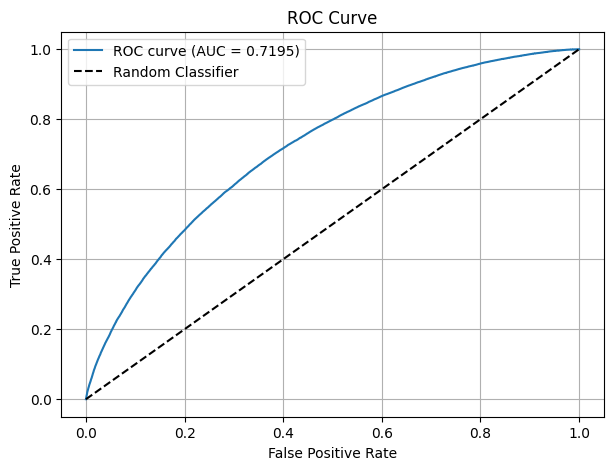

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, roc_thresh = roc_curve(trues, preds)

roc_auc = roc_auc_score(trues, preds)
print("ROC-AUC:", roc_auc)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Offline RL

In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os

def extract_rewards_chunk(df):
    if 'loan_status' not in df.columns: return None

    def map_status(x):
        x = str(x).lower()
        if "fully paid" in x: return 0
        if "charged off" in x or "default" in x: return 1
        return np.nan

    df["target"] = df["loan_status"].apply(map_status).astype("float")

    df = df.dropna(subset=["target"])

    rewards = df['total_pymnt'] - df['funded_amnt']
    return rewards.values

DATA_PATH = "accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv"
CHUNK_SIZE = 100_000
reward_list = []

print("Re-scanning data to extract Rewards...")
reader = pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE, low_memory=False)

for chunk in reader:
    r = extract_rewards_chunk(chunk)
    if r is not None:
        reward_list.append(r)

all_rewards = np.concatenate(reward_list)
print(f"Extracted {len(all_rewards)} reward values.")
X_train = np.load("/content/artifacts/X_train.npy")
X_test = np.load("/content/artifacts/X_test.npy")

from sklearn.model_selection import train_test_split
_, _, r_train, r_test = train_test_split(
    all_rewards, all_rewards, test_size=0.2, stratify=None, random_state=42
)

r_mean = r_train.mean()
r_std = r_train.std()

r_train_scaled = (r_train - r_mean) / r_std
r_test_scaled = (r_test - r_mean) / r_std

print(f"Rewards aligned. Train: {r_train.shape}, Test: {r_test.shape}")

Re-scanning data to extract Rewards...
Extracted 1348099 reward values.
Rewards aligned. Train: (1078479,), Test: (269620,)


In [35]:
class RLDataset(Dataset):
    def __init__(self, states, rewards):
        self.states = torch.FloatTensor(states)
        self.rewards = torch.FloatTensor(rewards).unsqueeze(1)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.rewards[idx]

class QNetwork(nn.Module):
    def __init__(self, input_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rl_train_loader = DataLoader(RLDataset(X_train, r_train_scaled), batch_size=1024, shuffle=True)
rl_test_loader = DataLoader(RLDataset(X_test, r_test_scaled), batch_size=4096, shuffle=False)

q_net = QNetwork(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(q_net.parameters(), lr=0.001)

print("Training Q-Network (Profit Estimator)")

EPOCHS = 10
for epoch in range(EPOCHS):
    q_net.train()
    total_loss = 0
    for states, rewards in rl_train_loader:
        states, rewards = states.to(device), rewards.to(device)

        pred_profit = q_net(states)

        loss = criterion(pred_profit, rewards)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | MSE Loss: {total_loss / len(rl_train_loader):.4f}")

print("RL Training Complete.")

Training Q-Network (Profit Estimator)
Epoch 1/10 | MSE Loss: 1.0001
Epoch 2/10 | MSE Loss: 1.0002
Epoch 3/10 | MSE Loss: 1.0001
Epoch 4/10 | MSE Loss: 1.0003
Epoch 5/10 | MSE Loss: 0.9998
Epoch 6/10 | MSE Loss: 0.9999
Epoch 7/10 | MSE Loss: 0.9995
Epoch 8/10 | MSE Loss: 0.9994
Epoch 9/10 | MSE Loss: 0.9991
Epoch 10/10 | MSE Loss: 0.9987
RL Training Complete.


Saved Q-Network to /content/artifacts/q_network.pth
       OFFLINE RL POLICY RESULTS       
1. BASELINE (Approve All 100% of Test Set)
   Loans Processed: 269,620
   Total Profit:    $108,351,657.31
   Avg Profit/Loan: $401.87

2. RL AGENT (Selective Approval)
   Loans Approved:  264,448 (98.1%)
   Total Profit:    $106,151,808.94
   Avg Profit/Loan: $401.41
----------------------------------------
NET IMPROVEMENT: $-2,199,848.37


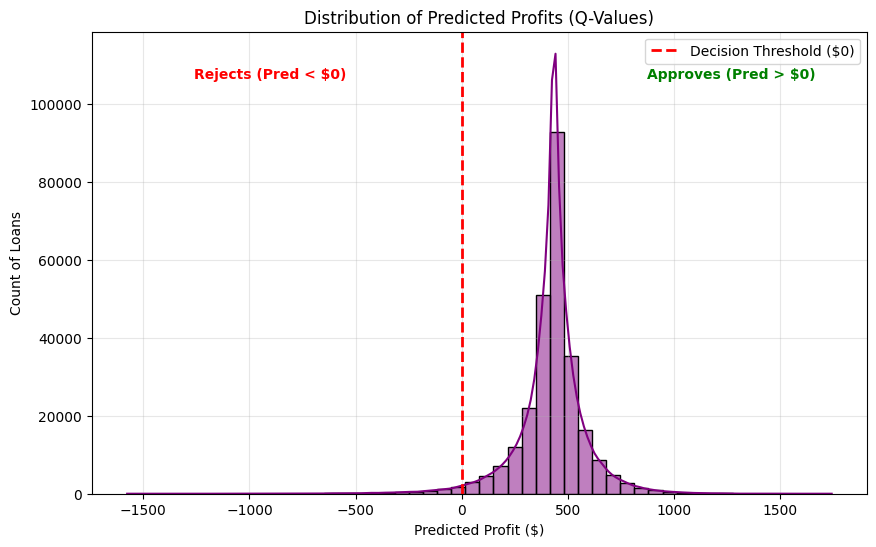

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

torch.save(q_net.state_dict(), "/content/artifacts/q_network.pth")
print("Saved Q-Network to /content/artifacts/q_network.pth")

q_net.eval()
all_pred_q = []
all_real_rewards = []

with torch.no_grad():
    for states, rewards in rl_test_loader:
        states = states.to(device)
        q_values = q_net(states)
        all_pred_q.append(q_values.cpu().numpy())

        all_real_rewards.append(rewards.numpy())

pred_q_scaled = np.concatenate(all_pred_q).flatten()
real_rewards_scaled = np.concatenate(all_real_rewards).flatten()

pred_profit_dollars = (pred_q_scaled * r_std) + r_mean
real_profit_dollars = (real_rewards_scaled * r_std) + r_mean

total_profit_baseline = real_profit_dollars.sum()
count_baseline = len(real_profit_dollars)
avg_profit_baseline = total_profit_baseline / count_baseline

approve_mask = pred_profit_dollars > 0
total_profit_rl = real_profit_dollars[approve_mask].sum()
count_rl = approve_mask.sum()
avg_profit_rl = total_profit_rl / count_rl if count_rl > 0 else 0

print("="*40)
print("       OFFLINE RL POLICY RESULTS       ")
print("="*40)

print(f"1. BASELINE (Approve All 100% of Test Set)")
print(f"   Loans Processed: {count_baseline:,}")
print(f"   Total Profit:    ${total_profit_baseline:,.2f}")
print(f"   Avg Profit/Loan: ${avg_profit_baseline:.2f}")

print("\n2. RL AGENT (Selective Approval)")
print(f"   Loans Approved:  {count_rl:,} ({count_rl/count_baseline*100:.1f}%)")
print(f"   Total Profit:    ${total_profit_rl:,.2f}")
print(f"   Avg Profit/Loan: ${avg_profit_rl:.2f}")

print("-" * 40)
improvement = total_profit_rl - total_profit_baseline
print(f"NET IMPROVEMENT: ${improvement:,.2f}")
print("="*40)

plt.figure(figsize=(10, 6))
sns.histplot(pred_profit_dollars, bins=50, kde=True, color='purple')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label="Decision Threshold ($0)")

plt.title("Distribution of Predicted Profits (Q-Values)")
plt.xlabel("Predicted Profit ($)")
plt.ylabel("Count of Loans")
plt.legend()
plt.grid(True, alpha=0.3)

plt.text(x=np.min(pred_profit_dollars)*0.8, y=plt.ylim()[1]*0.9,
         s="Rejects (Pred < $0)", color='red', fontweight='bold')
plt.text(x=np.max(pred_profit_dollars)*0.5, y=plt.ylim()[1]*0.9,
         s="Approves (Pred > $0)", color='green', fontweight='bold')

plt.show()